# GAN 

Our goal is to create a GAN to color black and white images. For this, we will use the ImageNet database.

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

## Model

For the purpose of pix2pix, the generator will follow an encoder-decoder architecture. The discriminator has to be adapted for a binary classification (Fake or Real).  
  

In [3]:
import torch.nn.functional as functionnal

In [4]:
class Conv_x2(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels

        self.conv_x2 = nn.Sequential( nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(self.mid_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(self.out_channels),
                                      nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_x2(x)

In [5]:
class Block_down_unet(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential (
            nn.MaxPool2d(kernel_size=2),
            Conv_x2(self.in_channels, self.out_channels)
        )

    def forward(self, x):
        return self.block(x)

In [6]:
class Block_up_unet(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        
        self.upsampling   = nn.ConvTranspose2d(self.in_channels, out_channels = self.in_channels // 2, kernel_size=2, stride=2)
        self.conv_x2      = Conv_x2(self.in_channels, self.out_channels)

    def forward(self, x, concat_tensor):
        x = self.upsampling(x)
        diffY = concat_tensor.size()[2] - x.size()[2]
        diffX = concat_tensor.size()[3] - x.size()[3]

        x = functionnal.pad(x, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
        x_res = torch.cat([concat_tensor, x], dim=1)

        return self.conv(x_res)
        

In [19]:
class UNet(nn.Module):

    def __init__(self, n_in_channels, n_out_channels, depth):
        super().__init__()

        self.n_in_channels  = n_in_channels
        self.n_out_channels = n_out_channels
        self.mid_channels_list = [32 * 2**i for i in range(depth)]
        self.down_part = nn.ModuleList()
        self.up_part   = nn.ModuleList()

        self.input_layer  = Conv_x2(self.n_in_channels, self.mid_channels_list[0])
        self.output_layer = Conv_x2(self.mid_channels_list[0], self.n_out_channels) 

        # Encoder path
        for i in range(depth):
            self.down_part.append(
                Block_down_unet(self.mid_channels_list[i], self.mid_channels_list[depth + 1])
            )
        # Up path
        for i in reversed(range(depth - 1)):
            self.up_part.append(
                Block_up_unet(self.mid_channels_list[i], self.mid_channels_list[i + 1])
            )

    def forward(self, x):
        down_block_outputs = []
        x = self.first_layer(x)
        down_block_outputs.append(x)

        # Encoder path
        for i, down_layer in enumerate(self.down_part):
            x = down_layer(x)
            if i != len(self.down_part):
                down_block_outputs.append(x)
        # Decoder path with res path
        for i, up_layer in enumerate(self.up_part):
            x = up_layer(x, down_block_outputs[-i - 1])

        return self.output_layer(x)


In [18]:
class Generator(nn.Module):
    """
        Encoder - Decoder architecture 
            --> Auto-encoder
            --> U-Net
    """
    def __init__(self, in_channels, out_channels, depth):
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.depth        = depth
        self.unet         = UNet(self.in_channels, self.out_channels, self.depth)

    def forward(self, x):
        return self.unet(x)

In [20]:
class NaiveDiscriminator(nn.Module):

    def __init__(self):
        raise NotImplemented

    def forward(self, x):
        raise NotImplemented

In [ ]:
class PatchDiscriminator(nn.Module):

    def __init__(self):
        raise NotImplemented

    def forward(self, x):
        raise NotImplemented

## Trainer

In [10]:
class Trainer:
    pass

## Data

- Stats on the dataset                    --> OK
- Display some images                     --> OK
- Create a Dataset class and Dataloader   --> OK
- Choose transforms                       --> OK
- Adapt it to the task (RGB to Lab)       --> OK

In [11]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

from skimage import color

In [12]:
class colorCIFAR10(datasets.CIFAR10):

    def __init__(self):
        super().__init__()
        self.transforms = transforms.Compose([transforms.ToTensor()
                                             ])

    def __getitem__(self, idx):

        image, _ = super().__getitem__(idx)
        # PIL to numpy array + Normalization
        image = np.array(image/255.)
        # from RGB to Lab
        image = color.rgb2lab(image)
        # from numpy array to Tensor
        image = self.transforms(image)
        # scaling to [-1 ; 1]
        L  = image[0,:,:] / 100. - 1
        ab = image[1:3,:,:] / 128.
        
        return {'L' : L, 'ab' : ab}


def create_dataloader(dataset, **kwargs):

    if "shuffle" in kwargs:
        _shuffle    = kwargs.get('shuffle')
    else:
        _shuffle = True
    if "batch_size" in kwargs:
        _batch_size = kwargs.get('batch_size')
    else:
        _batch_size = 32
    
    return DataLoader(dataset, shuffle=_shuffle, batch_size=_batch_size)
 

In [13]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset  = datasets.CIFAR10(root='./data', train=False, download=True)

train_loader = create_dataloader(trainset, shuffle=True, batch_size=32)
test_loader  = create_dataloader(testset, shuffle=False, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


Info of train dataset
dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
Number of data: 50000
Shape of data: (32, 32, 3)

Median:	 [123.0, 121.0, 104.0]
Mean:	 [125.306918046875, 122.950394140625, 113.86538318359375]
Std:	 [62.993219278136884, 62.08870764001421, 66.70489964063091]


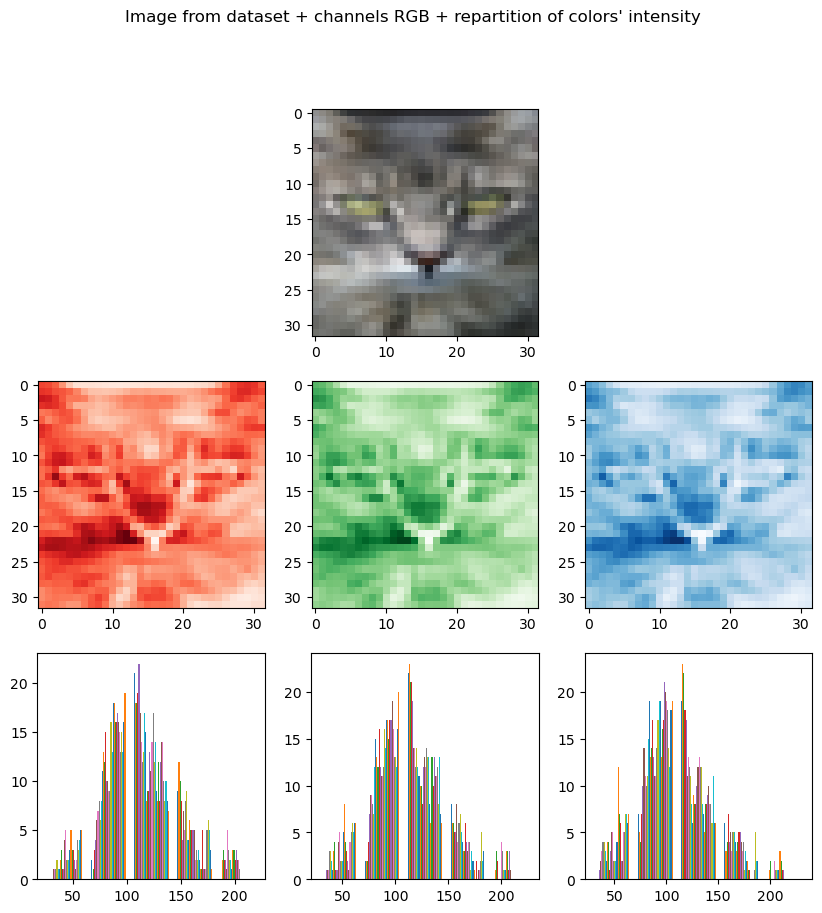

Info of eval dataset
dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
Number of data: 10000
Shape of data: (32, 32, 3)

Median:	 [124.0, 121.0, 105.0]
Mean:	 [126.02464140625, 123.70850419921875, 114.85431865234375]
Std:	 [62.89639134921991, 61.93752718231365, 66.70605639561605]


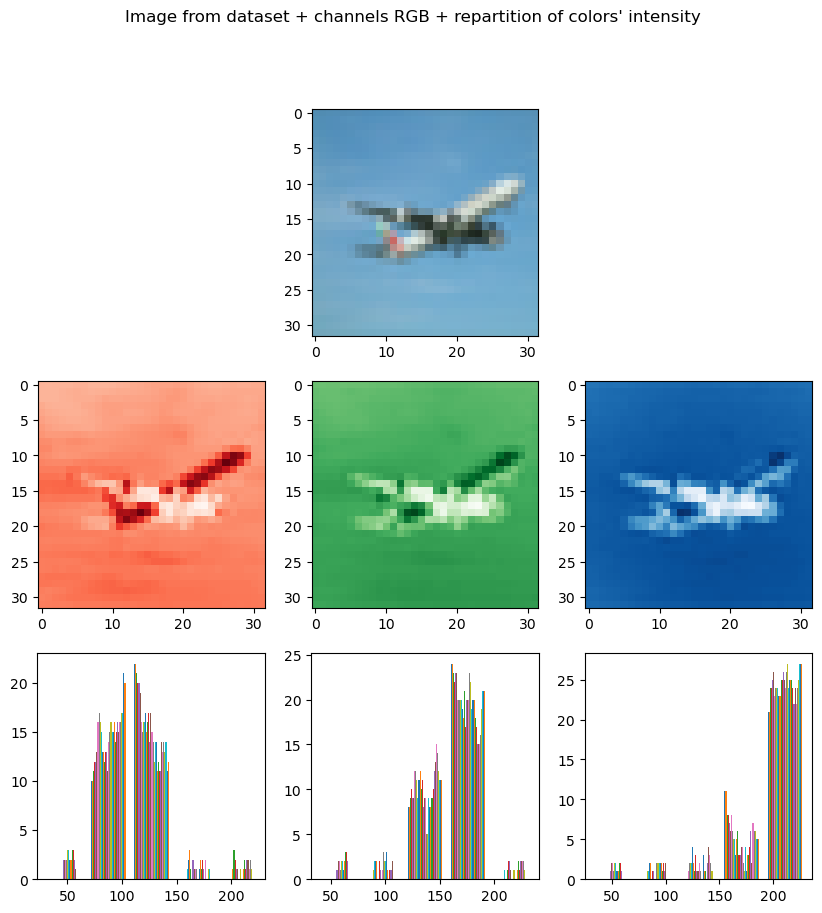

In [14]:
def get_data_info(dataset):
    """
        Get essential info 
    """
    # All atributes of the dataset
    print(dataset.__dict__.keys())
    # Numbers of element
    print(f"Number of data: {dataset.data.shape[0]}")
    # Shape of data
    print(f"Shape of data: {dataset.data.shape[1:]}\n")



def plot_image_RGB(dataset, image_idx):

    image = dataset.data[image_idx]

    fig, axs = plt.subplots(3,3, figsize=(10,10))
    channels = ['Reds', 'Greens', 'Blues']

    # Ground truth image
    axs[0,1].imshow(image)
    axs[0,0].axis('off')
    axs[0,2].axis('off')

    for i in range(3):
        # Display channel
        axs[1,i].imshow(image[:,:,i], cmap=channels[i])
        # Display hist of the channel
        axs[2,i].hist(image[:,:,i], bins=5)

    fig.suptitle("Image from dataset + channels RGB + repartition of colors' intensity")

    plt.show()



def get_stats(dataset):
    """
        Get statistical info on the dataset for each channel (RGB)
    """

    median = []
    mean   = []
    std    = []

    for i in range(3):
        median.append(np.median(dataset.data[:,:,:,i]))
        mean.append(np.mean(dataset.data[:,:,:,i]))
        std.append(np.std(dataset.data[:,:,:,i]))

    return median, mean, std



############################################

print("Info of train dataset")

get_data_info(trainset)

median, mean, std = get_stats(trainset)

print(f'Median:\t {median}')
print(f'Mean:\t {mean}')
print(f'Std:\t {std}')

plot_image_RGB(trainset, 8000)

print("Info of eval dataset")

get_data_info(testset)

median, mean, std = get_stats(testset)

print(f'Median:\t {median}')
print(f'Mean:\t {mean}')
print(f'Std:\t {std}')

plot_image_RGB(testset, 1010)

## Utils

## Main

In [15]:
def main():
    raise NotImplemented

In [16]:
if __name__ == "__main__":
    
    pass

## Performances